# Threat Report Summarizing

This notebook is used to experiment with the few-shot learning technique to automatically summarize threat reports and generate a mind map of the key findings.

## What is few-shot learning?

Few-shot learning in prompt engineering refers to the approach where a model, with minimal examples or 'shots', is trained to understand and perform a specific task. Instead of requiring vast amounts of data, this method leverages prior knowledge and limited new data to quickly adapt to new tasks or prompts.

The motivation behind this is to "teach" a model with specific information to minimize mistakes or errors. In this experiment, I apply this concept to threat report summarization, but it can be applied to any type of data.

## Prerequisites

You will need an OpenAI API key, but any model can be used.

Packages to Install:
* openai
* requests
* BeautifulSoup

## Limitations

In some instances, the mindmap generation might not be flawless and can encounter issues, especially with nested parentheses or brackets. These can be easily rectified either by rerunning the model or by manually modifying the mindmap code. Also keep in mind that this is a proof of concept that needs to be adjusted for your need. :) 

## Code

In [10]:
import requests
from bs4 import BeautifulSoup
from ipywidgets import widgets
from IPython.display import display
import cohere
import openai
import os
import time
import re
from ipywidgets import Output

output = Output()

# You need to configure you environement variable or to add your key here
openai.api_key = os.getenv("OPENAI_API_KEY")

# Function to scrape text from a URL
def scrape_text(url):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        page_content = response.content
        soup = BeautifulSoup(page_content, "html.parser")
        text = soup.get_text()
        return text
    else:
        return "Failed to scrape the website"

# Function to summarize the blog
def summarise(input_text):
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages= [
            {
                "role": "system",
                "content":"You are responsible for summarizing a threat report for a Threat Analyst. Write a paragraph that will summarize the main topic, the key findings, and all the detailed information relevant for a threat analyst such as detection opportunity iocs and TTPs. Use the title and add an emoji. Do not generate a bullet points list but rather multiple paragraphs."
            },

            {"role": "user", "content": input_text},
        ],
    )
    return response.choices[0].message['content']

# Function to generate a mindmap (few shot technique). 
# NB: the more shot you add the better the result will be
def run_models(input_text):
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages= [
            {
                "role": "system",
                "content":"You are tasked with creating an in-depth mindmap designed specifically for a threat analyst. This mindmap aims to visually organize key findings and crucial highlights from the text. Please adhere to the following guidelines: \n1. Avoid using hyphens in the text, as they cause errors in the Mermaid.js code \n2. Limit the number of primary nodes branching from the main node to four. These primary nodes should encapsulate the top four main themes. Add detailed sub-nodes to elaborate on these themes \n3. Incorporate icons where suitable to enhance readability and comprehension\n 4. Use single parentheses around each node to give them a rounded shape."
            },
            {
                "role": "user",
                "content": "Title: \ud83e\udda0 Lazarus Group's Infrastructure Reuse Leads to Discovery of New Malware\n\nThe Lazarus Group, a North Korean state-sponsored actor famous for its relentless cyber offensive actions, continues to adjust its tactics and expand its arsenal. Recently, the revealed an exploitation of the ManageEngine ServiceDesk vulnerability (CVE-2022-47966) in another campaign. This exposure led to deploying multiple threats, with a new one identified as CollectionRAT, alongside an already used threat named QuiteRAT. \n\nThe advanced malware CollectionRAT has standard remote access trojan (RAT) capabilities, being able to run arbitrary commands on an infected system. Our intense analysis linked CollectionRAT to Jupiter/EarlyRAT, a malware family somewhat known to be associated with Andariel, a subgroup under the Lazarus Group umbrella. Interestingly, the group is gradually increasing its reliance on open-source tools and frameworks in the initial access phase of its attacks, as shown by Lazarus' use of the DeimosC2 framework. \n\nThe Lazarus Group's unchanging use of certain infrastructures, despite them being well-documented by security researchers, is another noteworthy observation. Their modus operandi, captured in the repeated use of the same tactics, techniques, and procedures (TTPs), shows audacious assurance in their operations. But this approach also offers intelligence opportunities for security analysts on tracking these reusable infrastructure components. \n \nDespite their blatant actions, the Lazarus Group's dynamism is evident by their increasingly heavy reliance on using dual-use utilities for activities like reverse tunneling. Some of the reused infrastructure components hosted the new CollectionRAT malware, and an altered copy of PuTTY's Plink utility was downloaded onto compromised endpoints, further demonstrating Lazarus Group's rapid evolution. \n\nIn conclusion, the Lazarus Group continues to reuse and recycle its well-worn tactics while pushing ahead with new threats and evolving TTPs. This information highlights why there's a need for organized cooperation among threat researchers and the critical importance of staying up-to-date with the latest threat intelligence.",
            },
            {
                "role": "assistant",
                "content": "mindmap\nroot(Lazarus Group Threat Analysis)\n    (Infrastructure Reuse)\n      ::icon(fa fa-sync-alt)\n      (Used in latest campaign)\n      (Includes Plink, an open-source tool)\n      (Indicates confidence in operations)\n    (New Malware - CollectionRAT)\n      ::icon(fa fa-bug)\n      (Remote Access Trojan)\n      (Allows running arbitrary commands on infected system)\n      (Similarities to EarlyRAT malware)\n    (Shifting Tactics)\n      ::icon(fa fa-exchange-alt)\n      (Increased use of open-source tools and frameworks)\n      (Including DeimosC2 framework)\n    (Protection Measures)\n      ::icon(fa fa-shield-alt)\n      (Detection and blocking with Cisco security products)\n      (Indicators of Compromise available on GitHub)\n    (Threat Report Significance)\n      ::icon(fa fa-exclamation-circle)\n      (Highlighted continued activity of Lazarus Group)\n      (Essential for enhancing detection and response capabilities)",
            },
            {"role": "user", "content": input_text},
        ],
    )
    return response.choices[0].message['content']

# Function to generate MermaidJS HTML
def mermaid_chart(mindmap_code):
    html_code = f"""
    <html>
     <head>
      <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/5.15.1/css/all.min.css">
      <script src="https://cdn.jsdelivr.net/npm/mermaid@10/dist/mermaid.min.js">
      </script>
      <script>
        mermaid.initialize({{
            startOnLoad: true,
            flowchart: {{
                width: 1000,  // Set as per your requirements
                height: 800   // Set as per your requirements
            }}
        }});
      </script>
      <style>
        body {{
          margin: 0;
          height: 100vh;
          display: flex;
          justify-content: center;
          align-items: center;
          background-color: transparent;
        }}
    
        .mermaid {{
          background-color: transparent;
          transform: scale(1.5);  /* Adjust the scaling factor as needed */
          transform-origin: center;
          width: 100%;
          max-width: 1100px;  // Adjust as needed
          height: auto;
        }}
      </style>
     </head>
     <body>
      <div class="mermaid">
    {mindmap_code}
      </div>
     </body>
    </html>
    """

    with open("mindmap.html", "w") as f:
        f.write(html_code)

# Define button click event
def on_button_click(b):
    with output:
        url = url_input.value
        print("[+] Blog to summarize: " + url)
        scraped_text = scrape_text(url)
        
        if summarize_checkbox.value:
            summary = summarise(scraped_text)
            print("Summary:")
            print(summary)
            
        if mindmap_checkbox.value:
            #mindmap_code = run_models(scraped_text)
            mindmap_code = run_models(summary)
            print("Mindmap Code:")
            
            cleaned_mindmap = remove_nested_parentheses(mindmap_code)
            print(cleaned_mindmap)
            #print("#########")
            #print(mindmap_code)
            mermaid_chart(cleaned_mindmap)
            print("Mindmap has been saved to 'mindmap.html'.")

# Create widgets
url_input = widgets.Text(
    value='',
    placeholder='Enter URL to summarize',
    description='URL:',
    disabled=False
)

summarize_checkbox = widgets.Checkbox(
    value=False,
    description='Summarize',
    disabled=False,
    indent=False
)

mindmap_checkbox = widgets.Checkbox(
    value=False,
    description='Generate Mindmap',
    disabled=False,
    indent=False
)

# Create a button
button = widgets.Button(description="Go")
button.on_click(on_button_click)

# Display widgets
display(url_input, summarize_checkbox, mindmap_checkbox, button)
display(output)


Text(value='', description='URL:', placeholder='Enter URL to summarize')

Checkbox(value=False, description='Summarize', indent=False)

Checkbox(value=False, description='Generate Mindmap', indent=False)

Button(description='Go', style=ButtonStyle())

Output()

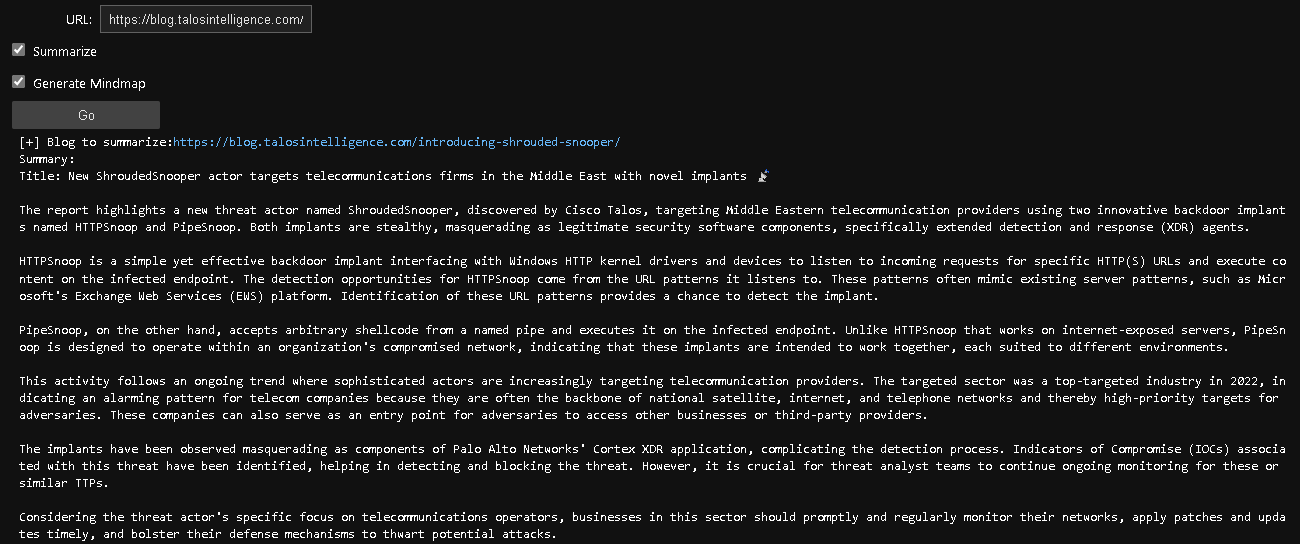

In [13]:
from IPython.display import display, Image
# Display the image in Jupyter Notebook
display(Image(filename="cisco1.png"))

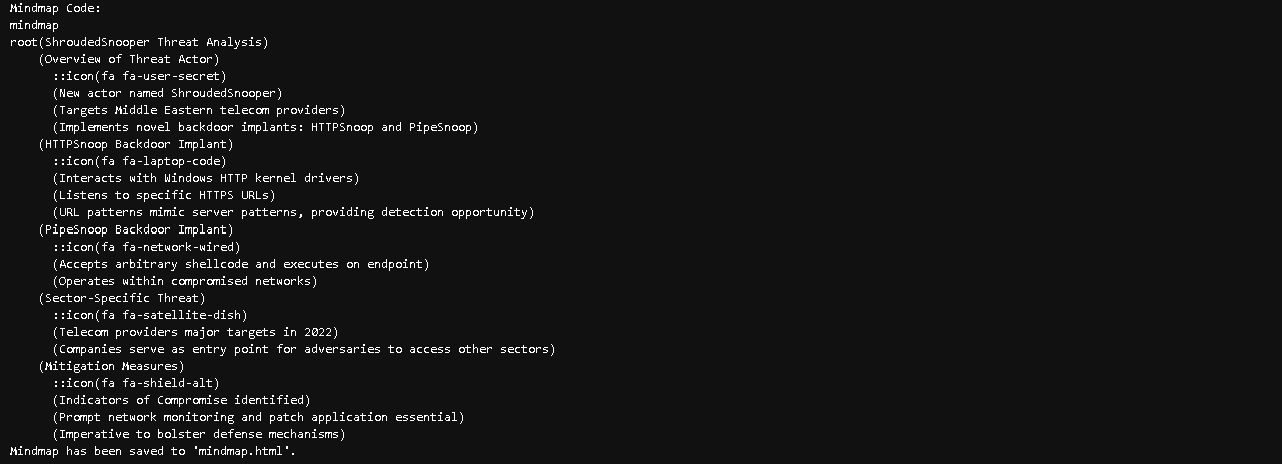

In [14]:
display(Image(filename="cisco2.png"))

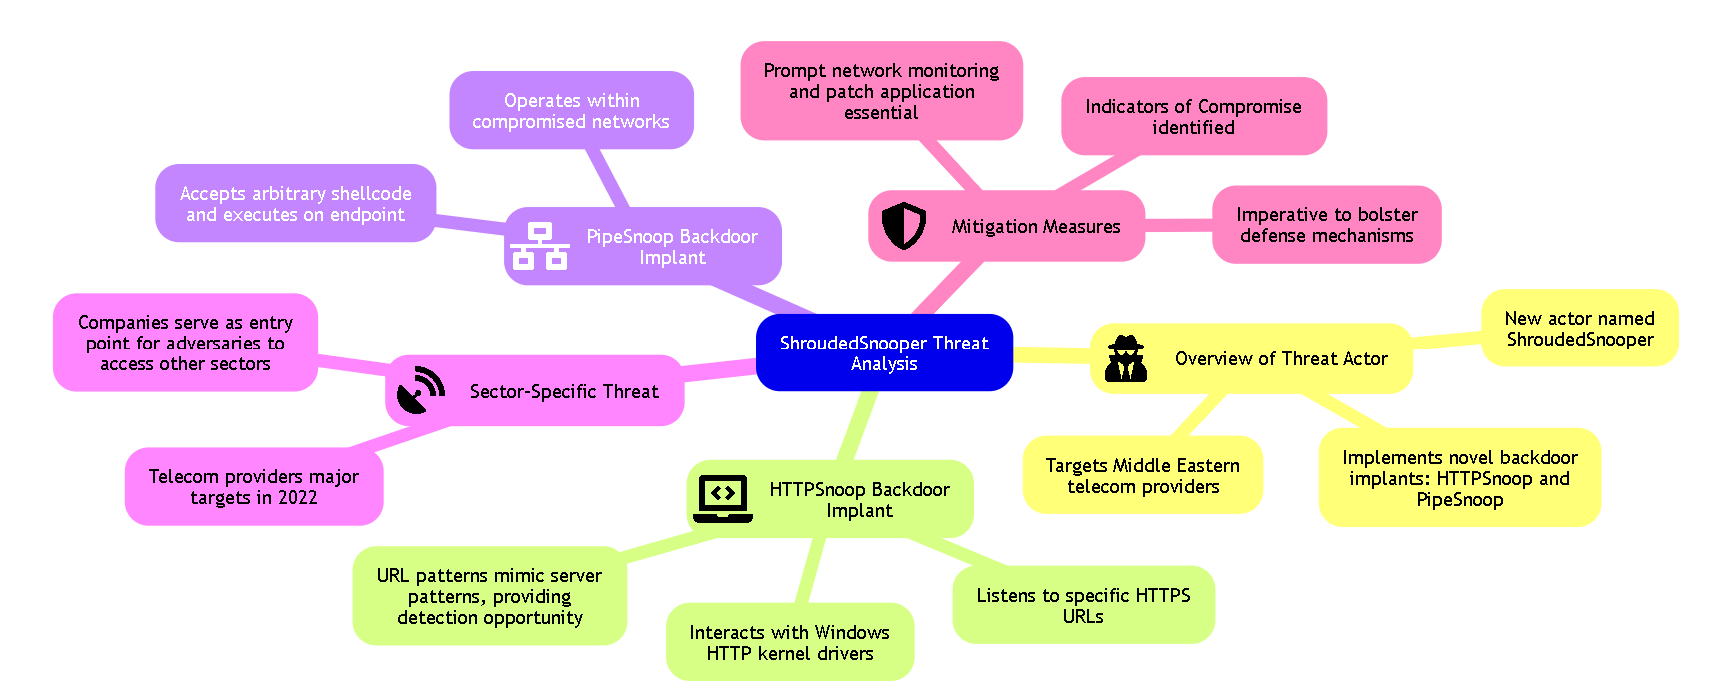

In [11]:

# Display the image in Jupyter Notebook
display(Image(filename="cisco_report.png"))

## The Intel Brief Newsletter 💌

Thank you for following my work. If you like this concept I am running this experiment over a newsletter called **The Intel Brief**. You can subscribe for free to get 5 summmaries of threat report including their visual every friday.

And if you like this content you can also follow me on social:

- [@fr0gger](https://twitter.com/fr0gger_)
- [Thomas-Roccia](https://www.linkedin.com/in/thomas-roccia/)

👉 [Subscribe to The Intel Brief here](https://store.securitybreak.io/)👈


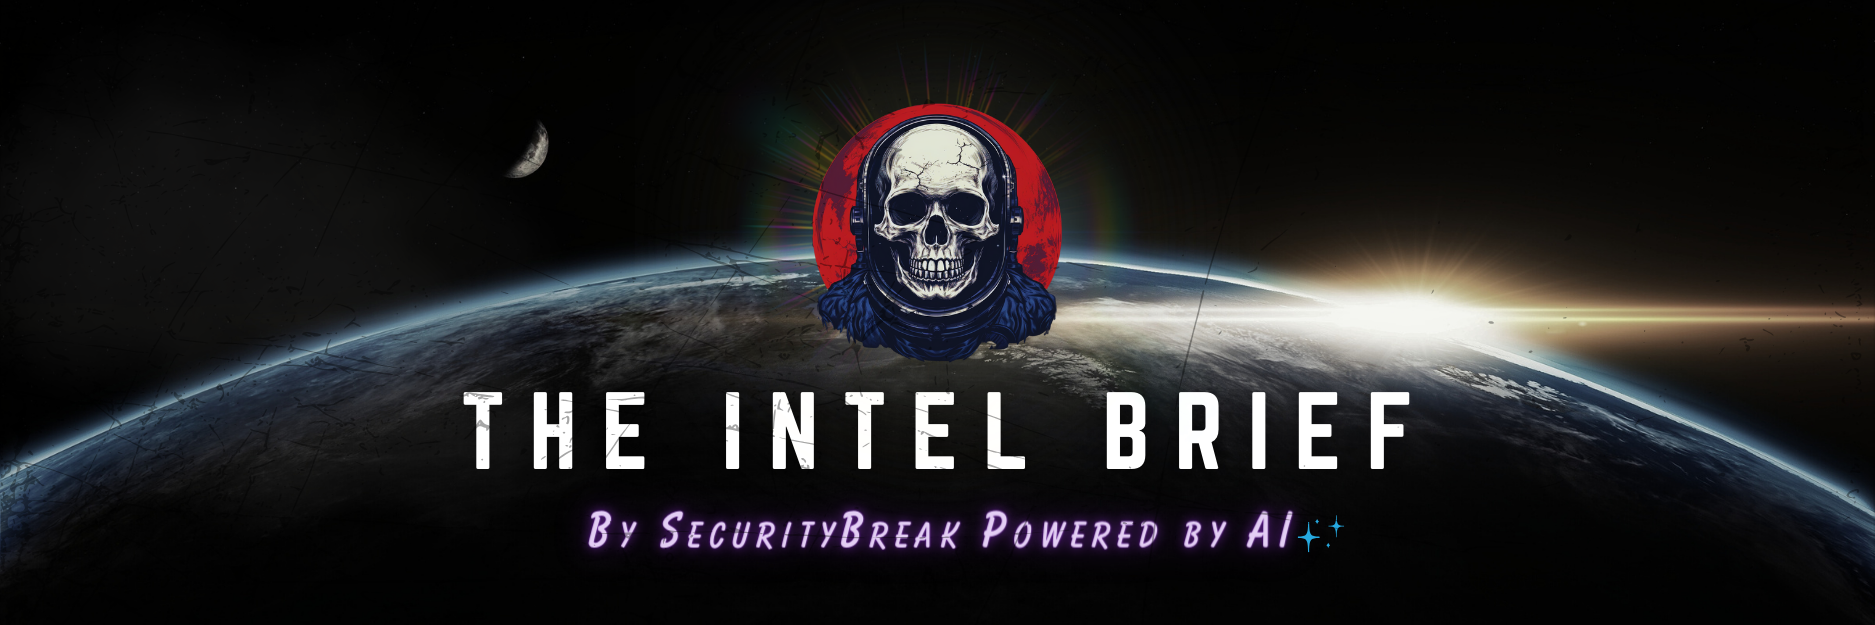

In [12]:
# Display the image in Jupyter Notebook
display(Image(filename="theintelbrief.png"))